In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [2]:
# Путь к обучающему набору данных
data_directory = "./preprocessed_data"

# Размер батча, размер изображений и количество шагов
batch_size = 128
img_size = (180, 360)
epochs = 5

# Преобразования для данных
data_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

In [3]:
# Создание экземпляра класса Dataset для обучающего набора данных
dataset = ImageFolder(root=data_directory, transform=data_transform)

# Разделение данных на обучающий и валидационный наборы
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Создание DataLoader для обучающего и валидационного наборов данных
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [4]:
# Архитектура модели
class MinecraftModel(nn.Module):
    def __init__(self, num_classes):
        super(MinecraftModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
# Создание экземпляра модели
model = MinecraftModel(num_classes=len(dataset.classes))

# Определение функции потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Перевод модели на GPU, если доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MinecraftModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=259200, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=41, bias=True)
  )
)

In [ ]:
# Обучение модели
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Оценка модели на валидационном наборе
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        accuracy = correct / total
        print(f'Шаг {epoch + 1}/{epochs}, Ошибка: {val_loss/len(val_loader)}, Точность: {accuracy}')


In [6]:
# Название и путь сохранения модели
model_save_path = "./minecraft_model.pth"

In [8]:
# Анализ точности на тестовой выборке
model = MinecraftModel(num_classes=len(dataset.classes))
model.load_state_dict(torch.load(model_save_path, map_location='cuda'))
model.eval()

def calculate_accuracy(loader, model):
    model.eval()
    correct_per_class = {class_idx: 0 for class_idx in range(len(dataset.classes))}
    total_per_class = {class_idx: 0 for class_idx in range(len(dataset.classes))}

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct = predicted.eq(labels)
            
            for class_idx in range(len(dataset.classes)):
                class_mask = labels == class_idx
                correct_per_class[class_idx] += correct[class_mask].sum().item()
                total_per_class[class_idx] += class_mask.sum().item()

    accuracy_per_class = {class_idx: correct_per_class[class_idx] / total_per_class[class_idx] for class_idx in range(len(dataset.classes))}
    average_accuracy = sum(accuracy_per_class.values()) / len(accuracy_per_class)
    
    return accuracy_per_class, average_accuracy

test_dataset = ImageFolder(root="./train_data", transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Оценка accuracy на тестовой выборке
test_accuracy_per_class, test_average_accuracy = calculate_accuracy(test_loader, model)

# Вывед результатов оценки
print("Точность по классам:")
for class_idx, accuracy in test_accuracy_per_class.items():
    print(f"Класс {class_idx}: {accuracy}")

print("\nУсредненная точность:", test_average_accuracy)


Accuracy по классам:
Class 0: 0.375
Class 1: 0.5
Class 2: 0.8181818181818182
Class 3: 0.0
Class 4: 1.0
Class 5: 1.0
Class 6: 1.0
Class 7: 1.0
Class 8: 0.0
Class 9: 0.9
Class 10: 0.0
Class 11: 0.0
Class 12: 1.0
Class 13: 0.0
Class 14: 0.0
Class 15: 1.0
Class 16: 0.0
Class 17: 1.0
Class 18: 1.0
Class 19: 0.0
Class 20: 1.0
Class 21: 1.0
Class 22: 0.5384615384615384
Class 23: 1.0
Class 24: 0.46153846153846156
Class 25: 1.0
Class 26: 0.0
Class 27: 0.16666666666666666
Class 28: 0.0
Class 29: 0.0
Class 30: 0.9411764705882353
Class 31: 0.09090909090909091
Class 32: 1.0
Class 33: 1.0
Class 34: 1.0
Class 35: 1.0
Class 36: 0.3
Class 37: 0.9285714285714286
Class 38: 0.875
Class 39: 1.0
Class 40: 0.0

Усредненная точность (Average Accuracy): 0.5828172067052985


In [ ]:
# Сохранение модели
torch.save(model.state_dict(), model_save_path)
print('Модель сохранена')

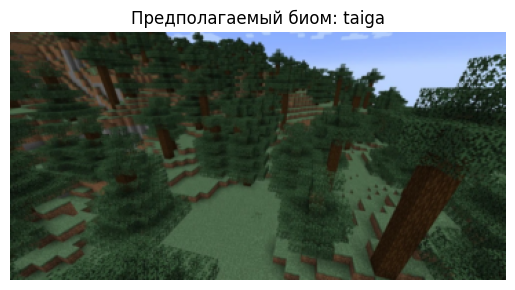

Inference time: 0.030515432357788086 seconds


In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import time

# Функция для загрузки изображения из скриншота
def load_screenshot(image_path):
    image = Image.open(image_path).convert('RGB')
    image = data_transform(image)
    image = image.unsqueeze(0)  # Добавляем размерность батча
    return image

# Путь к скриншоту для тестирования
screenshot_path = "./my_screen/Taiga.jpg"

# Загрузка модели и установка ее в режим оценки
model = MinecraftModel(num_classes=len(dataset.classes))
model.load_state_dict(torch.load(model_save_path, map_location='cpu'))  # Загрузка на CPU
model.eval()

# Загрузка скриншота для тестирования
screenshot = load_screenshot(screenshot_path)

start_time = time.time()
# Передача скриншота через модель
with torch.no_grad():
    output = model(screenshot)
end_time = time.time()

# Получение предсказания биома
predicted_class = torch.argmax(output).item()
predicted_biome = dataset.classes[predicted_class]

# Копирование тензора на устройстве CPU перед отображением
screenshot = screenshot.squeeze(0).numpy()

plt.figure()
plt.imshow(screenshot.transpose(1, 2, 0))  # Переставляем оси для отображения
plt.title(f"Предполагаемый биом: {predicted_biome}")
plt.axis('off')
plt.show()

print(f"Inference time: {end_time - start_time} seconds")


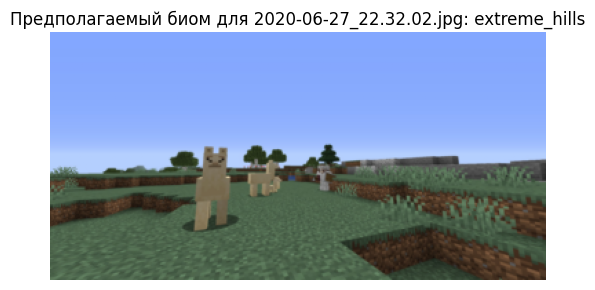

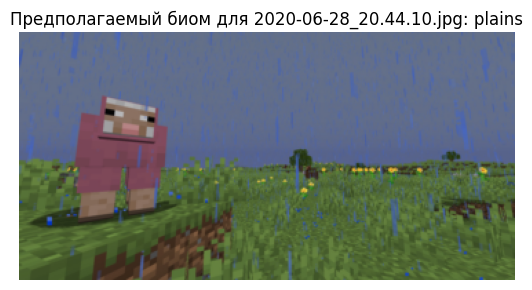

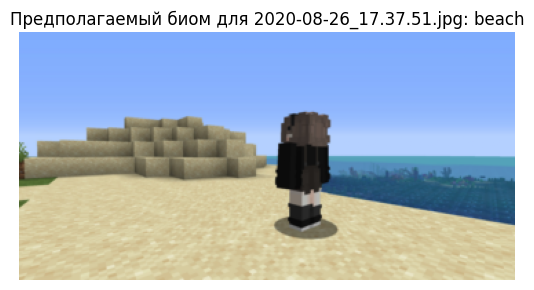

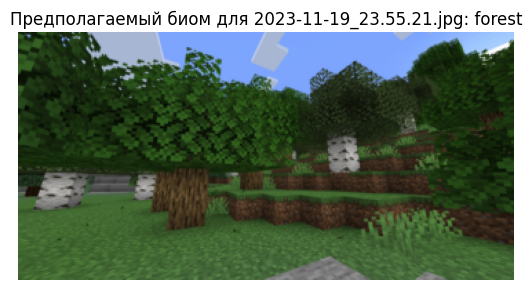

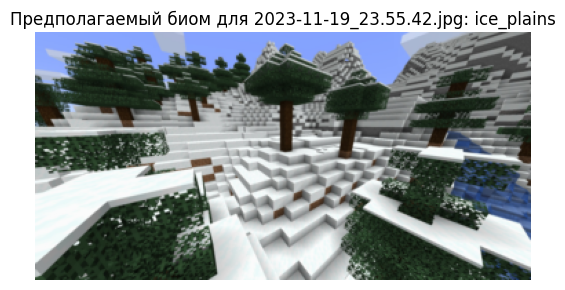

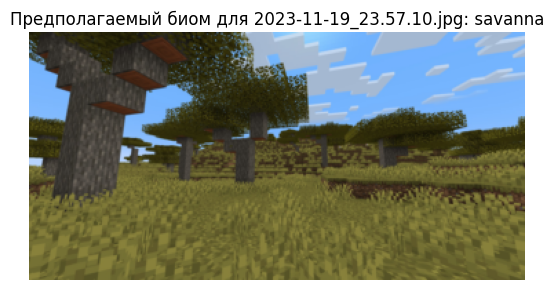

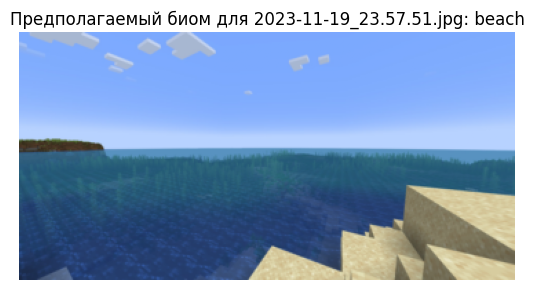

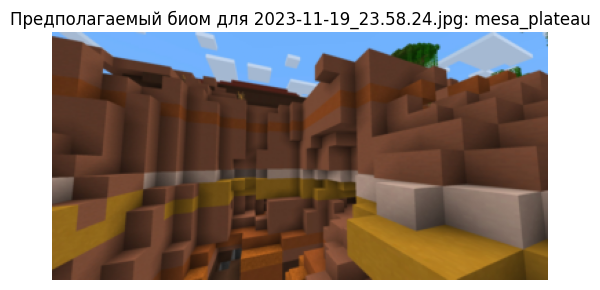

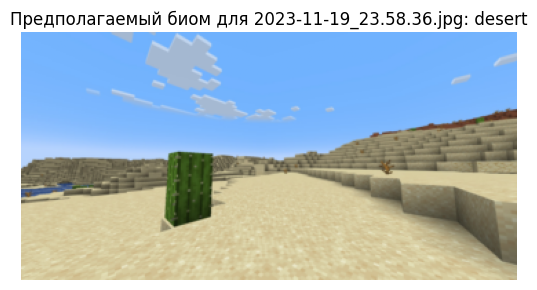

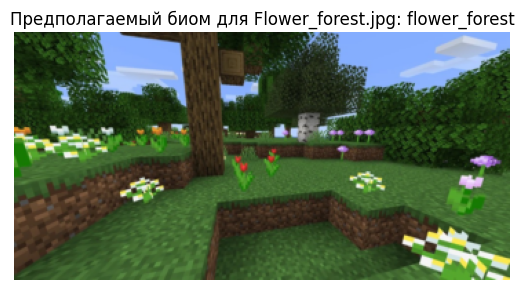

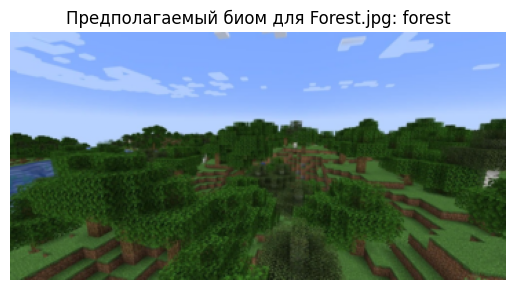

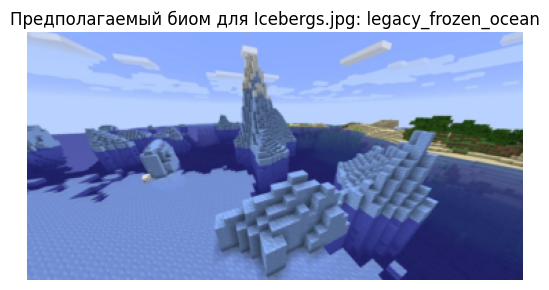

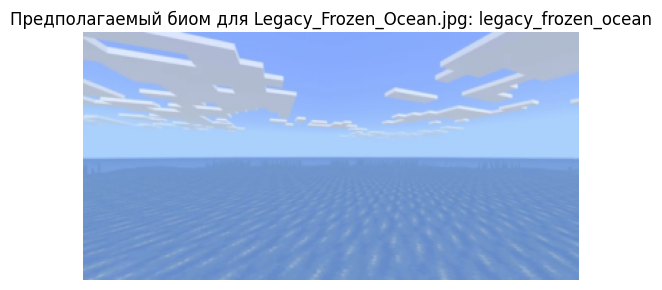

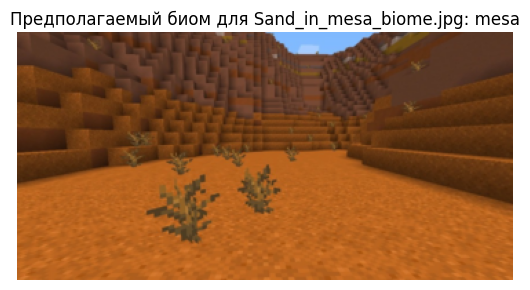

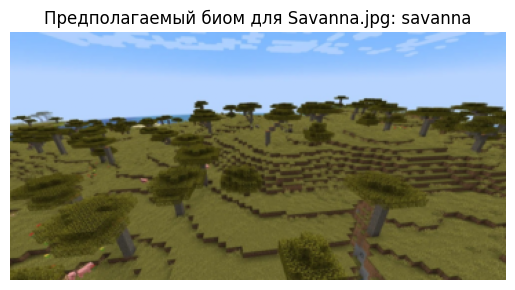

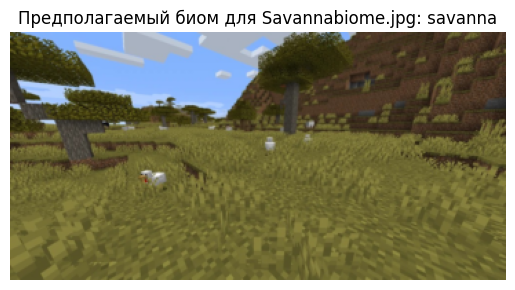

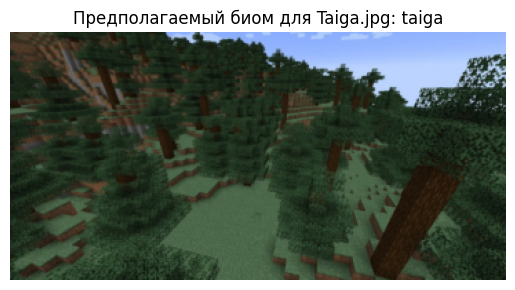

In [9]:
from os import listdir
from os.path import isfile, join

# Путь к папке со скриншотами
screenshots_folder = "./my_screen"

# Получаем список всех файлов в папке
screenshot_files = [f for f in listdir(screenshots_folder) if isfile(join(screenshots_folder, f))]

# Загрузка модели и установка ее в режим оценки
model = MinecraftModel(num_classes=len(dataset.classes))
model.load_state_dict(torch.load(model_save_path, map_location='cpu'))
model.eval()

# Проход по каждому изображению в папке
for screenshot_file in screenshot_files:
    # Полный путь к изображению
    screenshot_path = join(screenshots_folder, screenshot_file)

    # Загрузка скриншота для тестирования
    screenshot = load_screenshot(screenshot_path)

    # Передача скриншота через модель
    with torch.no_grad():
        output = model(screenshot)

    # Получение предсказания биома
    predicted_class = torch.argmax(output).item()
    predicted_biome = dataset.classes[predicted_class]

    screenshot = screenshot.squeeze(0).numpy()

    # Отображение изображения и предсказанного биома
    plt.figure()
    plt.imshow(screenshot.transpose(1, 2, 0))  # Переставляем оси для отображения
    plt.title(f"Предполагаемый биом для {screenshot_file}: {predicted_biome}")
    plt.axis('off')
    plt.show()
